In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PATH_CHANGEDIS = "../data_csv/changedis.csv"
PATH_EV = "../data_csv/ev_battery.csv"

데이터로드 및 데이터 전처리 

In [33]:
changedis = pd.read_csv(PATH_CHANGEDIS)
ev = pd.read_csv(PATH_EV)

changedis["DATE_TIME"] = pd.to_datetime(changedis["DATE_TIME"], errors="coerce")
changedis = changedis.dropna(subset=["DATE_TIME"]).sort_values("DATE_TIME").reset_index(drop=True)

need_cols = [
    "DATE_TIME",
    "battery_soc",
    "charge_power_kw",
    "discharge_power_kw",
    "load_served_kw",
    "load_deficit_kw",
    "is_charging",
    "is_discharging",
]
changedis = changedis[need_cols].copy()

changedis.head(3), changedis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE_TIME           67698 non-null  datetime64[ns]
 1   battery_soc         67698 non-null  float64       
 2   charge_power_kw     67698 non-null  float64       
 3   discharge_power_kw  67698 non-null  float64       
 4   load_served_kw      67698 non-null  float64       
 5   load_deficit_kw     67698 non-null  float64       
 6   is_charging         67698 non-null  bool          
 7   is_discharging      67698 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(5)
memory usage: 3.2 MB


(   DATE_TIME  battery_soc  charge_power_kw  discharge_power_kw  \
 0 2020-05-15          0.5              0.0                 0.0   
 1 2020-05-15          0.5              0.0                 0.0   
 2 2020-05-15          0.5              0.0                 0.0   
 
    load_served_kw  load_deficit_kw  is_charging  is_discharging  
 0           0.000            0.135        False           False  
 1           0.135            0.000        False           False  
 2           0.135            0.000        False           False  ,
 None)

In [34]:
# 🔥 [필수] DATE_TIME 기준으로 ESS 단위 집계
changedis_agg = (
    changedis
    .groupby("DATE_TIME", as_index=False)
    .agg({
        "load_served_kw": "sum",
        "load_deficit_kw": "sum",
        "charge_power_kw": "sum",
        "discharge_power_kw": "sum",
        "battery_soc": "mean",
        "is_charging": "max",
        "is_discharging": "max",
    })
)

changedis = changedis_agg.copy()

ESS 파라미터 정의 

In [35]:
ev_need = [
    "capacity_kWh",
    "charge_rate_c",
    "discharge_rate_c",
    "avg_soc_percent",
    "capacity_retained_percent",
]
ev2 = ev[ev_need].copy()
ev2 = ev2.dropna(subset=["capacity_kWh", "charge_rate_c", "discharge_rate_c", "avg_soc_percent"])

bat = ev2.iloc[0].copy()

ENERGY_MAX = float(bat["capacity_kWh"])  # kWh
P_CH_MAX = float(bat["charge_rate_c"]) * ENERGY_MAX
P_DIS_MAX = float(bat["discharge_rate_c"]) * ENERGY_MAX
SOC_INIT = float(bat["avg_soc_percent"]) / 100.0

SOH = float(bat["capacity_retained_percent"]) / 100.0 if pd.notna(bat.get("capacity_retained_percent", np.nan)) else 1.0
ENERGY_MAX_EFF = ENERGY_MAX * SOH

ENERGY_MAX, P_CH_MAX, P_DIS_MAX, SOC_INIT, SOH

(65.54, 32.77, 98.76878, 0.5196000000000001, 0.8175)

demand 정의 및 dt, 공통 규칙 

In [36]:
df = changedis.set_index("DATE_TIME").sort_index()

# demand(요구부하) = served + deficit
base = df["load_served_kw"] + df["load_deficit_kw"]

# 피크를 인위적으로 주입 (배터리 제어 실험용)
df["demand_kw"] = base * (
    1.0
    + 0.3 * np.sin(np.linspace(0, 10*np.pi, len(base)))
    + 0.2 * (base > base.quantile(0.8))
)

# dt(hours)
dt_hours = df.index.to_series().diff().dt.total_seconds().median() / 3600.0
if not np.isfinite(dt_hours) or dt_hours <= 0:
    dt_hours = 1.0

# ✅ 공통 규칙 1) 피크 기준선: actual 상위 5%
threshold = df["demand_kw"].quantile(0.95)

# ✅ 공통 규칙 2) 예측 기반 완화 강도: 10%
alpha = 0.10

dt_hours, threshold, alpha

(np.float64(0.25), np.float64(3.843984285348109), 0.1)

EMS ESS 시뮬레이터 

In [37]:
def run_ems_ess(demand_kw: pd.Series,
                mode: str,
                threshold: float,
                alpha: float,
                energy_max_kwh: float,
                p_dis_max_kw: float,
                soc_init_ratio: float,
                dt_hours: float):
    """
    mode:
      - "reactive": actual 기준 (사후)
      - "proactive": forecast 기준 (선제)  -> 다음 step shift(-1)
    공통 규칙:
      discharge_target = alpha * (signal - threshold)  (signal>threshold일 때만)
    """

    idx = demand_kw.index
    n = len(demand_kw)

    # forecast(선제) 신호
    if mode == "proactive":
        signal = demand_kw.shift(-1).fillna(demand_kw.iloc[-1])
    else:
        signal = demand_kw

    soc = soc_init_ratio * energy_max_kwh
    soc_trace = np.zeros(n)
    load_adj = np.zeros(n)
    discharge_kw = np.zeros(n)

    for t in range(n):
        actual = float(demand_kw.iloc[t])
        sig = float(signal.iloc[t])

        # ✅ 공통 규칙(완화량): alpha * (sig - threshold), 단 sig>threshold
        if (sig > threshold) and (soc > 0):
            discharge_target = alpha * (sig - threshold)
        else:
            discharge_target = 0.0

        # 물리 제약: 출력제약 + SOC로 가능한 전력 + actual 이상 방전 금지
        max_by_soc = soc / dt_hours
        dis = min(discharge_target, p_dis_max_kw, max_by_soc, actual)

        # SOC 업데이트(kWh)
        soc = soc - dis * dt_hours
        if soc < 0:
            soc = 0.0
        if soc > energy_max_kwh:
            soc = energy_max_kwh

        discharge_kw[t] = dis
        soc_trace[t] = soc
        load_adj[t] = actual - dis

    out = pd.DataFrame({
        "demand_kw": demand_kw.values,
        "load_adj_kw": load_adj,
        "discharge_kw": discharge_kw,
        "soc_kwh": soc_trace,
    }, index=idx)

    return out

Reactive & Proactive

In [38]:
out_reactive = run_ems_ess(
    demand_kw=df["demand_kw"],
    mode="reactive",
    threshold=threshold,
    alpha=alpha,
    energy_max_kwh=ENERGY_MAX_EFF,
    p_dis_max_kw=P_DIS_MAX,
    soc_init_ratio=SOC_INIT,
    dt_hours=dt_hours
)

out_proactive = run_ems_ess(
    demand_kw=df["demand_kw"],
    mode="proactive",
    threshold=threshold,
    alpha=alpha,
    energy_max_kwh=ENERGY_MAX_EFF,
    p_dis_max_kw=P_DIS_MAX,
    soc_init_ratio=SOC_INIT,
    dt_hours=dt_hours
)

out_reactive.head(3), out_proactive.head(3)

(                     demand_kw  load_adj_kw  discharge_kw    soc_kwh
 DATE_TIME                                                           
 2020-05-15 00:00:00   2.970000     2.970000           0.0  27.839622
 2020-05-15 00:15:00   2.978592     2.978592           0.0  27.839622
 2020-05-15 00:30:00   2.987182     2.987182           0.0  27.839622,
                      demand_kw  load_adj_kw  discharge_kw    soc_kwh
 DATE_TIME                                                           
 2020-05-15 00:00:00   2.970000     2.970000           0.0  27.839622
 2020-05-15 00:15:00   2.978592     2.978592           0.0  27.839622
 2020-05-15 00:30:00   2.987182     2.987182           0.0  27.839622)

지표 계산 

In [39]:
def calc_metrics(out: pd.DataFrame, threshold: float, dt_hours: float, energy_max_kwh: float):
    peak_exceed = int((out["load_adj_kw"] > threshold).sum())

    ramp = out["load_adj_kw"].diff().abs()
    avg_ramp = float(ramp.mean())
    risky_ramp = int((ramp > ramp.quantile(0.95)).sum())

    exceed_amount = (out["load_adj_kw"] - threshold).clip(lower=0)
    load_deficit_sum = float(exceed_amount.sum())

    ess_throughput_kwh = float((out["discharge_kw"] * dt_hours).sum())

    soc_violation = int(((out["soc_kwh"] <= 1e-9) | (out["soc_kwh"] >= (energy_max_kwh - 1e-9))).sum())

    return {
        "peak_exceed_count": peak_exceed,
        "avg_ramp": avg_ramp,
        "risky_ramp": risky_ramp,
        "load_deficit_sum": load_deficit_sum,
        "ESS_throughput_kwh": ess_throughput_kwh,
        "SOC_violation_count": soc_violation,
    }

m_re = calc_metrics(out_reactive, threshold, dt_hours, ENERGY_MAX_EFF)
m_pr = calc_metrics(out_proactive, threshold, dt_hours, ENERGY_MAX_EFF)

result = pd.DataFrame([
    {"scenario": "Reactive EMS (actual trigger)", **m_re},
    {"scenario": "Proactive EMS (shift trigger)", **m_pr},
])

result

,scenario,peak_exceed_count,avg_ramp,risky_ramp,load_deficit_sum,ESS_throughput_kwh,SOC_violation_count
0,Reactive EMS (actual trigger),163,0.006101,163,1.656912,0.046025,0
1,Proactive EMS (shift trigger),163,0.006101,163,1.657273,0.046025,0


시각화

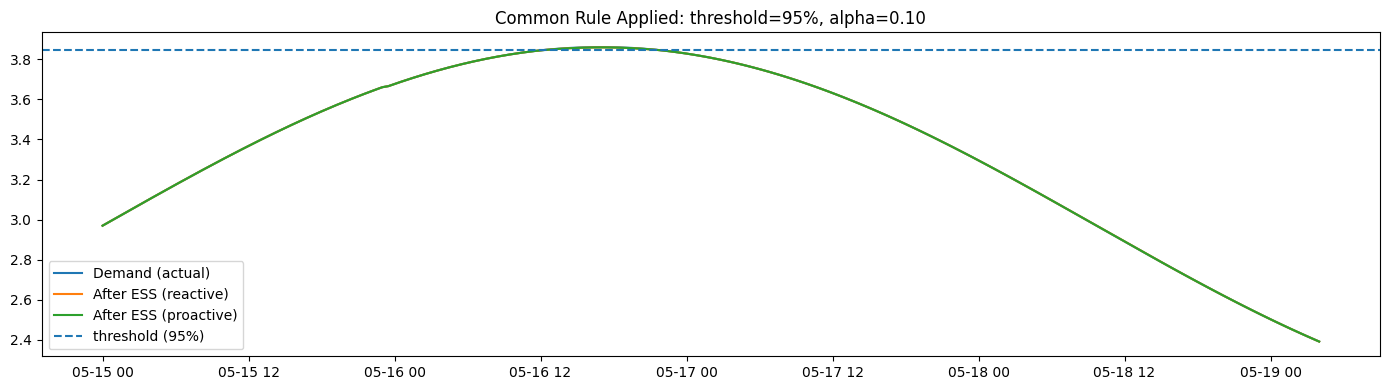

In [40]:
n = 400

plt.figure(figsize=(14,4))
plt.plot(out_reactive.index[:n], out_reactive["demand_kw"].values[:n], label="Demand (actual)")
plt.plot(out_reactive.index[:n], out_reactive["load_adj_kw"].values[:n], label="After ESS (reactive)")
plt.plot(out_proactive.index[:n], out_proactive["load_adj_kw"].values[:n], label="After ESS (proactive)")
plt.axhline(threshold, linestyle="--", label="threshold (95%)")
plt.legend()
plt.title("Common Rule Applied: threshold=95%, alpha=0.10")
plt.tight_layout()
plt.show()

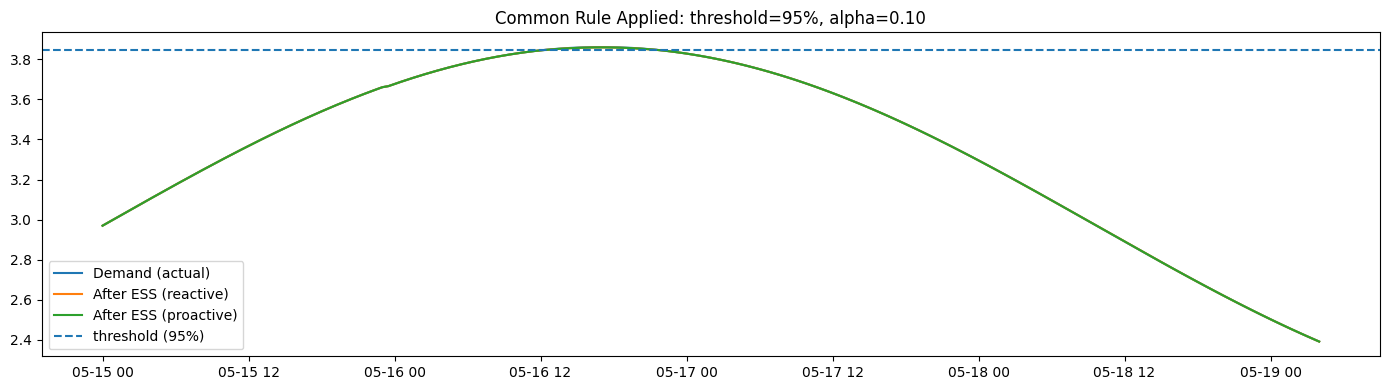

In [41]:
n = 400

plt.figure(figsize=(14,4))
plt.plot(out_reactive.index[:n], out_reactive["demand_kw"].values[:n], label="Demand (actual)")
plt.plot(out_reactive.index[:n], out_reactive["load_adj_kw"].values[:n], label="After ESS (reactive)")
plt.plot(out_proactive.index[:n], out_proactive["load_adj_kw"].values[:n], label="After ESS (proactive)")
plt.axhline(threshold, linestyle="--", label="threshold (95%)")
plt.legend()
plt.title("Common Rule Applied: threshold=95%, alpha=0.10")
plt.tight_layout()
plt.show()

csv 파일 저장

In [42]:
result.to_csv("../data_csv/core4_ipynb2_metrics.csv", index=False)
out_reactive.reset_index().rename(
    columns={"index": "timestamp"}
).to_csv("../data_csv/core4_ipynb2_reactive_ts.csv", index=False)

out_proactive.reset_index().rename(
    columns={"index": "timestamp"}
).to_csv("../data_csv/core4_ipynb2_proactive_ts.csv", index=False)
result

,scenario,peak_exceed_count,avg_ramp,risky_ramp,load_deficit_sum,ESS_throughput_kwh,SOC_violation_count
0,Reactive EMS (actual trigger),163,0.006101,163,1.656912,0.046025,0
1,Proactive EMS (shift trigger),163,0.006101,163,1.657273,0.046025,0
